In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 증강해서 학습한 결과 테스트 성능이 떨어져 증강은 최종 미선택

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import random
import pandas as pd
from tqdm import tqdm

class FeatureAugmenter:
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)

    def time_masking(self, features, n_mask=2, mask_size=0.1):
        """시간 마스킹"""
        features = np.array(features, dtype=np.float32)
        feature_length = len(features)
        mask_length = int(feature_length * mask_size)

        for _ in range(n_mask):
            start = np.random.randint(0, feature_length - mask_length)
            features[start:start + mask_length] = 0

        return features

    def frequency_masking(self, features, n_mask=2, mask_size=0.1):
        """주파수 마스킹"""
        features = np.array(features, dtype=np.float32)
        feature_dim = len(features)
        mask_length = int(feature_dim * mask_size)

        for _ in range(n_mask):
            start = np.random.randint(0, feature_dim - mask_length)
            features[start:start + mask_length] = 0

        return features

    def gaussian_noise(self, features, noise_range=(0.02, 0.06)):
        """가우시안 노이즈"""
        features = np.array(features, dtype=np.float32)
        noise_factor = np.random.uniform(*noise_range)
        noise = np.random.normal(0, noise_factor, features.shape)
        return features + noise

    def pitch_shift(self, features, shift_range=(-2, 2)):
        """피치 시프트"""
        features = np.array(features, dtype=np.float32)
        shift = np.random.uniform(*shift_range)
        return np.roll(features, int(shift), axis=0)

    def magnitude_warp(self, features, sigma=0.1, knot=4):
        """크기 왜곡"""
        features = np.array(features, dtype=np.float32)
        orig_steps = np.arange(len(features))
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
        warp_steps = (len(features)-1)/(knot+1)*np.arange(knot+2)
        warper = interp1d(warp_steps, random_warps, kind='linear')
        return features * warper(orig_steps)

    def formant_shift(self, features, shift_range=(0.8, 1.2)):
        """포먼트 시프트 시뮬레이션"""
        features = np.array(features, dtype=np.float32)
        shift_factor = np.random.uniform(*shift_range)
        # MFCC의 첫 번째 몇 개 계수에 더 큰 영향을 줌
        weights = np.linspace(1, 0.1, len(features))
        shift = (shift_factor - 1) * weights
        return features * (1 + shift)

    def compression_simulation(self, features, compression_factor=(0.7, 0.95)):
        """오디오 압축 시뮬레이션"""
        features = np.array(features, dtype=np.float32)
        factor = np.random.uniform(*compression_factor)
        # 비선형 압축 시뮬레이션
        return np.sign(features) * (np.abs(features) ** factor)

    def phase_distortion(self, features, distortion_factor=(0.1, 0.3)):
        """위상 왜곡 시뮬레이션"""
        features = np.array(features, dtype=np.float32)
        factor = np.random.uniform(*distortion_factor)
        distortion = np.sin(2 * np.pi * features * factor)
        return features + (distortion * 0.3)

    def spectral_contrast(self, features, contrast_factor=(0.8, 1.2)):
        """스펙트럴 대비 조정"""
        features = np.array(features, dtype=np.float32)
        factor = np.random.uniform(*contrast_factor)
        mean = np.mean(features)
        return (features - mean) * factor + mean

    def augment_features(self, features, label):
        """모든 증강 기법을 적용하여 새로운 데이터 생성"""
        augmented_features = []

        # 기본 증강
        augmented_features.extend([
            self.time_masking(features),
            self.frequency_masking(features),
            self.gaussian_noise(features),
            self.pitch_shift(features),
            self.magnitude_warp(features)
        ])

        # Fake 오디오 탐지를 위한 특화된 증강
        augmented_features.extend([
            self.formant_shift(features),
            self.compression_simulation(features),
            self.phase_distortion(features),
            self.spectral_contrast(features)
        ])

        # 복합 증강 (Fake 탐지에 효과적인 조합)
        aug1 = self.compression_simulation(self.phase_distortion(features))
        aug2 = self.formant_shift(self.spectral_contrast(features))
        aug3 = self.magnitude_warp(self.compression_simulation(features))
        augmented_features.extend([aug1, aug2, aug3])

        return augmented_features

def augment_dataset(csv_path):
    """데이터셋 중 training 데이터만 증강 수행"""
    print("데이터 로딩 중...")
    df = pd.read_csv(csv_path)

    # 특징 컬럼 식별
    feature_cols = [col for col in df.columns if col not in ['file_path', 'label', 'category', 'split']]

    # training 데이터만 선택
    train_df = df[df['split'] == 'training'].copy()
    other_df = df[df['split'] != 'training'].copy()

    # training 데이터 준비
    features = train_df[feature_cols].values
    labels = train_df['label'].values
    file_paths = train_df['file_path'].values
    categories = train_df['category'].values if 'category' in train_df.columns else None

    augmenter = FeatureAugmenter()

    # 증강된 데이터를 저장할 리스트
    augmented_data = {
        'features': [features[i] for i in range(len(features))],
        'labels': [labels[i] for i in range(len(labels))],
        'file_paths': [file_paths[i] for i in range(len(file_paths))],
        'categories': [categories[i] for i in range(len(categories))] if categories is not None else None,
        'splits': ['training' for _ in range(len(features))]
    }

    print("Training 데이터 증강 시작...")
    for i in tqdm(range(len(features)), desc="Augmenting training data"):
        aug_samples = augmenter.augment_features(features[i], labels[i])

        for j, aug_sample in enumerate(aug_samples):
            augmented_data['features'].append(aug_sample)
            augmented_data['labels'].append(labels[i])
            augmented_data['file_paths'].append(f"{file_paths[i]}_aug_{j+1}")
            if categories is not None:
                augmented_data['categories'].append(categories[i])
            augmented_data['splits'].append('training')

    print("증강된 데이터 저장 중...")
    # 증강된 training 데이터로 데이터프레임 생성
    augmented_train_df = pd.DataFrame(augmented_data['features'], columns=feature_cols)
    augmented_train_df.insert(0, 'file_path', augmented_data['file_paths'])
    augmented_train_df.insert(1, 'label', augmented_data['labels'])
    if categories is not None:
        augmented_train_df.insert(2, 'category', augmented_data['categories'])
    augmented_train_df.insert(3, 'split', augmented_data['splits'])

    # 증강된 training 데이터와 나머지 데이터 합치기
    final_df = pd.concat([augmented_train_df, other_df], ignore_index=True)

    # 증강된 데이터셋 저장
    output_path = csv_path.replace('.csv', '_augmented.csv')
    final_df.to_csv(output_path, index=False)

    print(f"\n원본 training 데이터 크기: {len(train_df)}")
    print(f"증강된 training 데이터 크기: {len(augmented_train_df)}")
    print(f"전체 데이터셋 크기: {len(final_df)}")
    print(f"증강된 데이터셋이 {output_path}에 저장되었습니다.")

    return final_df
if __name__ == "__main__":
    csv_path = "/content/drive/Shareddrives/Data/전처리/features.csv"
    augmented_df = augment_dataset(csv_path)

데이터 로딩 중...


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# 라이브러리 임포트

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, LayerNormalization, MultiHeadAttention,
    Dropout, Input, GlobalAveragePooling1D, Conv1D,
    LSTM, Bidirectional, BatchNormalization, GRU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, classification_report, roc_curve, auc,
    precision_recall_curve, confusion_matrix
)
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingClassifier
import seaborn as sns
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# GPU 메모리 설정 최적화
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
            print(f"GPU device found: {device}")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

# 메모리 릭 방지를 위한 세션 설정
tf.keras.backend.clear_session()

GPU device found: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 모델 구조 정의

In [ ]:
# F1-Score 메트릭을 케라스 클래스로 정의
@tf.keras.utils.register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred > 0.5, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

# 시퀀스 생성 함수
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps + 1):
        X_seq.append(X[i:i + timesteps])
        y_seq.append(y[i + timesteps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시퀀스 예측 집계 함수
def aggregate_predictions(X_test, model, timesteps):
    predictions = np.zeros(len(X_test))
    counts = np.zeros(len(X_test))

    # 모든 가능한 시퀀스 생성
    for i in range(len(X_test) - timesteps + 1):
        sequence = X_test[i:i + timesteps]
        pred = model.predict(np.array([sequence]), verbose=0)[0][0]
        predictions[i + timesteps - 1] += pred
        counts[i + timesteps - 1] += 1

    # 시퀀스에 포함되지 않는 초기 데이터 포인트들 처리
    for i in range(timesteps - 1):
        # 첫 timesteps 개의 데이터로 시퀀스 생성
        sequence = X_test[0:timesteps]
        pred = model.predict(np.array([sequence]), verbose=0)[0][0]
        predictions[i] = pred
        counts[i] = 1

    # 평균 계산
    counts[counts == 0] = 1  # 0으로 나누기 방지
    predictions = predictions / counts

    return predictions

# 모델 평가 시각화 함수
def plot_training_curves(history):
    metrics = ['loss', 'accuracy', 'f1_score']
    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Model {metric.replace("_", " ").title()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.replace("_", " ").title())
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name=""):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(data_path, is_training=True):
    print("Loading data from:", data_path)
    data = pd.read_csv(data_path)
    print("Total data size:", len(data))

    if is_training:
        print("After category filter:", len(data))

        train_data = data[data['split'] == 'training']
        val_data = data[data['split'] == 'validation']
        test_data = data[data['split'] == 'testing']
        print(f"Split sizes - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

        feature_cols = [col for col in data.columns if col not in ['file_path', 'label', 'category', 'split']]

        X_train = train_data[feature_cols].values
        y_train = train_data['label'].values
        X_val = val_data[feature_cols].values
        y_val = val_data['label'].values
        X_test = test_data[feature_cols].values
        y_test = test_data['label'].values

        return X_train, y_train, X_val, y_val, X_test, y_test, feature_cols
    else:
        feature_cols = [col for col in data.columns if col not in ['file_path', 'label']]
        X = data[feature_cols].values
        y = data['label'].values
        return X, y, feature_cols

In [ ]:
import os
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

class AudioFakeDetectorBase:
    def __init__(self, timesteps=15, learning_rate=0.0005):
        self.timesteps = timesteps
        self.learning_rate = learning_rate
        self.scaler = None
        self.encoder = LabelEncoder()
        self.model = None
        self.f1_metric = F1Score()
        self.model_name = None
        self.encoder.fit(['fake', 'real'])

    def save_scaler(self, path):
        """스케일러를 저장하는 메서드"""
        if self.scaler is not None:
            os.makedirs(path, exist_ok=True)
            scaler_path = os.path.join(path, f'{self.model_name}_scaler.joblib')
            joblib.dump(self.scaler, scaler_path)
            print(f"Scaler saved to {scaler_path}")

    def load_scaler(self, path):
        """스케일러를 로드하는 메서드"""
        scaler_path = os.path.join(path, f'{self.model_name}_scaler.joblib')
        if os.path.exists(scaler_path):
            self.scaler = joblib.load(scaler_path)
            print(f"Scaler loaded from {scaler_path}")
            return True
        return False

    def create_sequences(self, X, y, timesteps):
        """시퀀스 데이터 생성"""
        X_seq, y_seq = [], []
        for i in range(len(X) - timesteps + 1):
            X_seq.append(X[i:i + timesteps])
            y_seq.append(y[i + timesteps - 1])
        return np.array(X_seq), np.array(y_seq)

    def aggregate_predictions(self, X_test, timesteps):
        """예측 결과 집계"""
        predictions = np.zeros(len(X_test))
        counts = np.zeros(len(X_test))

        for i in range(len(X_test) - timesteps + 1):
            sequence = X_test[i:i + timesteps]
            pred = self.model.predict(np.array([sequence]), verbose=0)[0][0]
            predictions[i + timesteps - 1] += pred
            counts[i + timesteps - 1] += 1

        for i in range(timesteps - 1):
            sequence = X_test[0:timesteps]
            pred = self.model.predict(np.array([sequence]), verbose=0)[0][0]
            predictions[i] = pred
            counts[i] = 1

        counts[counts == 0] = 1
        predictions = predictions / counts
        return predictions

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention
from keras.models import Model

@keras.saving.register_keras_serializable()
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="gelu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


class AudioFakeDetectorTransformer(AudioFakeDetectorBase):
    def __init__(self, timesteps=15, learning_rate=0.0005):
        super().__init__(timesteps, learning_rate)
        self.model_name = "transformer"

    def create_model(self, input_shape):
        inputs = Input(shape=input_shape)

        x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(inputs)
        x = LayerNormalization(epsilon=1e-6)(x)

        transformer_blocks = [
            TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256, rate=0.1),
            TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256, rate=0.1),
            TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256, rate=0.1)
        ]

        for transformer_block in transformer_blocks:
            x = transformer_block(x)

        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation='gelu')(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='gelu')(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        optimizer = AdamW(
            learning_rate=self.learning_rate,
            weight_decay=0.01,
            beta_1=0.9,
            beta_2=0.999,
            clipnorm=1.0
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', self.f1_metric]
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, model_save_path):
        # 스케일러 초기화 및 저장
        if not self.scaler:
            self.scaler = StandardScaler()
            X_train_scaled = self.scaler.fit_transform(X_train)
            self.save_scaler(os.path.dirname(model_save_path))
        else:
            X_train_scaled = self.scaler.transform(X_train)

        X_val_scaled = self.scaler.transform(X_val)
        y_train_encoded = self.encoder.transform(y_train)
        y_val_encoded = self.encoder.transform(y_val)

        X_train_seq, y_train_seq = self.create_sequences(X_train_scaled, y_train_encoded, self.timesteps)
        X_val_seq, y_val_seq = self.create_sequences(X_val_scaled, y_val_encoded, self.timesteps)

        self.model = self.create_model((self.timesteps, X_train.shape[1]))

        callbacks = [
            EarlyStopping(monitor='val_f1_score', patience=5, mode='max', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=3, mode='max', min_lr=1e-6),
            ModelCheckpoint(model_save_path, monitor='val_f1_score', mode='max', save_best_only=True)
        ]

        class_weights = dict(zip(
            np.unique(y_train_seq),
            1 / np.bincount(y_train_seq.astype(int)) * len(y_train_seq) / 2.0
        ))

        history = self.model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=100, batch_size=1024, callbacks=callbacks,
            class_weight=class_weights, verbose=1
        )
        return history

    def predict(self, X):
        if self.scaler is None or self.model is None:
            raise ValueError("Model must be trained before making predictions")
        X_scaled = self.scaler.transform(X)
        return self.aggregate_predictions(X_scaled, self.timesteps)

    def evaluate(self, X_test, y_test):
        y_pred_proba = self.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        y_test_encoded = self.encoder.transform(y_test)

        print(f"\n{self.model_name.upper()} Model Test Results:")
        print(classification_report(y_test_encoded, y_pred))
        plot_roc_curve(y_test_encoded, y_pred_proba, self.model_name)
        return y_pred_proba

In [ ]:
class AudioFakeDetectorLSTM(AudioFakeDetectorBase):
    def __init__(self, timesteps=15, learning_rate=0.0005):
        super().__init__(timesteps, learning_rate)
        self.model_name = "lstm"

    def create_model(self, input_shape):
        model = Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
            BatchNormalization(),
            Dropout(0.5),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
            BatchNormalization(),
            Dropout(0.5),
            Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
            BatchNormalization(),
            Dropout(0.5),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        optimizer = Adam(
            learning_rate=self.learning_rate,
            clipnorm=1.0,
            beta_1=0.9,
            beta_2=0.999
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', self.f1_metric]
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, model_save_path):
        # 스케일러 초기화 및 저장
        if not self.scaler:
            self.scaler = StandardScaler()
            X_train_scaled = self.scaler.fit_transform(X_train)
            self.save_scaler(os.path.dirname(model_save_path))
        else:
            X_train_scaled = self.scaler.transform(X_train)

        X_val_scaled = self.scaler.transform(X_val)
        y_train_encoded = self.encoder.transform(y_train)
        y_val_encoded = self.encoder.transform(y_val)

        X_train_seq, y_train_seq = self.create_sequences(X_train_scaled, y_train_encoded, self.timesteps)
        X_val_seq, y_val_seq = self.create_sequences(X_val_scaled, y_val_encoded, self.timesteps)

        self.model = self.create_model((self.timesteps, X_train.shape[1]))

        callbacks = [
            EarlyStopping(monitor='val_f1_score', patience=5, mode='max', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=3, mode='max', min_lr=1e-6),
            ModelCheckpoint(model_save_path, monitor='val_f1_score', mode='max', save_best_only=True)
        ]

        class_weights = dict(zip(
            np.unique(y_train_seq),
            1 / np.bincount(y_train_seq.astype(int)) * len(y_train_seq) / 2.0
        ))

        history = self.model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=100, batch_size=1024, callbacks=callbacks,
            class_weight=class_weights, verbose=1
        )
        return history

    def predict(self, X):
        if self.scaler is None or self.model is None:
            raise ValueError("Model must be trained before making predictions")
        X_scaled = self.scaler.transform(X)
        return self.aggregate_predictions(X_scaled, self.timesteps)

    def evaluate(self, X_test, y_test):
        y_pred_proba = self.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        y_test_encoded = self.encoder.transform(y_test)

        print(f"\n{self.model_name.upper()} Model Test Results:")
        print(classification_report(y_test_encoded, y_pred))
        plot_roc_curve(y_test_encoded, y_pred_proba, self.model_name)
        return y_pred_proba

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Input, GRU, Bidirectional,
    BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os
from sklearn.metrics import classification_report

class AudioFakeDetectorGRU(AudioFakeDetectorBase):
    def __init__(self, timesteps=15, learning_rate=0.0005):
        super().__init__(timesteps, learning_rate)
        self.model_name = "gru"

    def create_model(self, input_shape):
        model = Sequential([
            Input(shape=input_shape),
            Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.001))),
            BatchNormalization(),
            Dropout(0.4),
            Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.001))),
            BatchNormalization(),
            Dropout(0.4),
            Bidirectional(GRU(32, kernel_regularizer=l2(0.001))),
            Dense(1, activation='sigmoid')
        ])

        optimizer = Adam(
            learning_rate=self.learning_rate,
            clipnorm=1.0,
            beta_1=0.9,
            beta_2=0.999
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', self.f1_metric]
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, model_save_path):
        # 스케일러 초기화 및 저장
        if not self.scaler:
            self.scaler = StandardScaler()
            X_train_scaled = self.scaler.fit_transform(X_train)
            self.save_scaler(os.path.dirname(model_save_path))
        else:
            X_train_scaled = self.scaler.transform(X_train)

        X_val_scaled = self.scaler.transform(X_val)
        y_train_encoded = self.encoder.transform(y_train)
        y_val_encoded = self.encoder.transform(y_val)

        X_train_seq, y_train_seq = self.create_sequences(X_train_scaled, y_train_encoded, self.timesteps)
        X_val_seq, y_val_seq = self.create_sequences(X_val_scaled, y_val_encoded, self.timesteps)

        self.model = self.create_model((self.timesteps, X_train.shape[1]))

        callbacks = [
            EarlyStopping(monitor='val_f1_score', patience=5, mode='max', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=3, mode='max', min_lr=1e-6),
            ModelCheckpoint(model_save_path, monitor='val_f1_score', mode='max', save_best_only=True)
        ]

        class_weights = dict(zip(
            np.unique(y_train_seq),
            1 / np.bincount(y_train_seq.astype(int)) * len(y_train_seq) / 2.0
        ))

        history = self.model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=100, batch_size=1024, callbacks=callbacks,
            class_weight=class_weights, verbose=1
        )
        return history

    def predict(self, X):
        if self.scaler is None or self.model is None:
            raise ValueError("Model must be trained before making predictions")
        X_scaled = self.scaler.transform(X)
        return self.aggregate_predictions(X_scaled, self.timesteps)

    def evaluate(self, X_test, y_test):
        y_pred_proba = self.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        y_test_encoded = self.encoder.transform(y_test)

        print(f"\n{self.model_name.upper()} Model Test Results:")
        print(classification_report(y_test_encoded, y_pred))
        plot_roc_curve(y_test_encoded, y_pred_proba, self.model_name)
        return y_pred_proba

# 평가 시각화 및 학습

Initializing models...

Loading training data...
Loading data from: /content/drive/Shareddrives/Data/전처리/features.csv
Total data size: 100436
After category filter: 100436
Split sizes - Train: 78030, Val: 15868, Test: 6538

Preparing GRU model...
Scaler saved to saved_models/gru_scaler.joblib
Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.9227 - f1_score: 0.4988 - loss: 0.8813 - val_accuracy: 0.9963 - val_f1_score: 0.8844 - val_loss: 0.4810 - learning_rate: 5.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9976 - f1_score: 0.4990 - loss: 0.4173 - val_accuracy: 0.9971 - val_f1_score: 0.8849 - val_loss: 0.2885 - learning_rate: 5.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9985 - f1_score: 0.5029 - loss: 0.2501 - val_accuracy: 0.9973 - val_f1_score: 0.8851 - val_loss: 0.1850 - learning_rate: 5.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9988 - f1_score: 0.4996 - loss: 0.1595 - val_

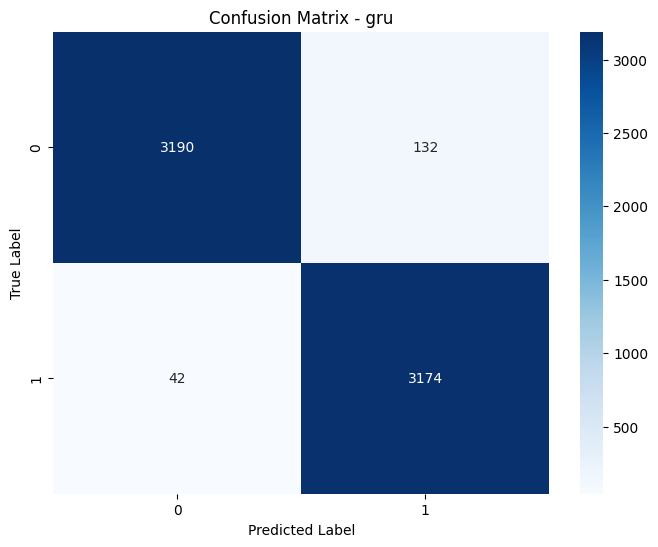

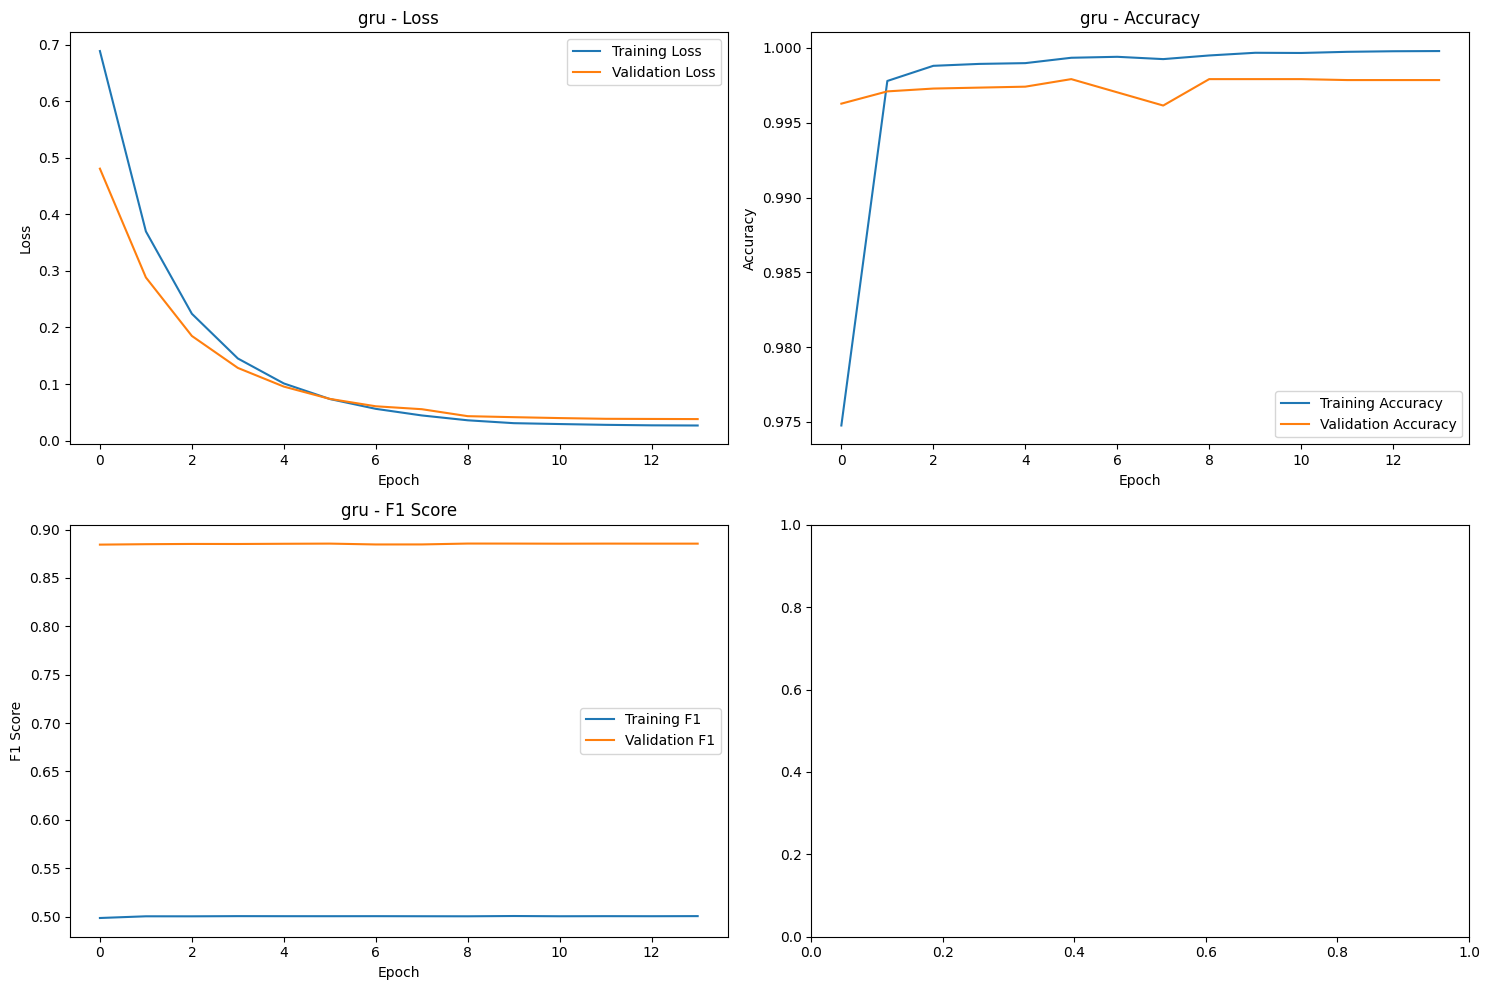


Preparing LSTM model...
Scaler saved to saved_models/lstm_scaler.joblib
Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7611 - f1_score: 0.5009 - loss: 9.1584 - val_accuracy: 0.9937 - val_f1_score: 0.8829 - val_loss: 5.5396 - learning_rate: 5.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9901 - f1_score: 0.5015 - loss: 4.6631 - val_accuracy: 0.9941 - val_f1_score: 0.8833 - val_loss: 2.7240 - learning_rate: 5.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9948 - f1_score: 0.4985 - loss: 2.2898 - val_accuracy: 0.9955 - val_f1_score: 0.8842 - val_loss: 1.3553 - learning_rate: 5.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9956 - f1_score: 0.5024 - loss: 1.1431 - val_accuracy: 0.9912 - val_f1_score: 0.8837 - val_loss: 0.7187 - learning_rate: 5.0000e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9968 - f1_score: 0.5026 - loss: 0.5955 - val_accuracy: 0.9967 - val_

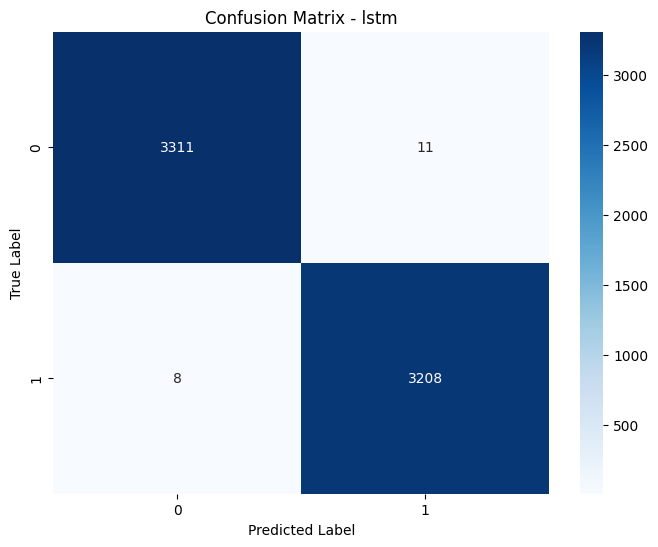

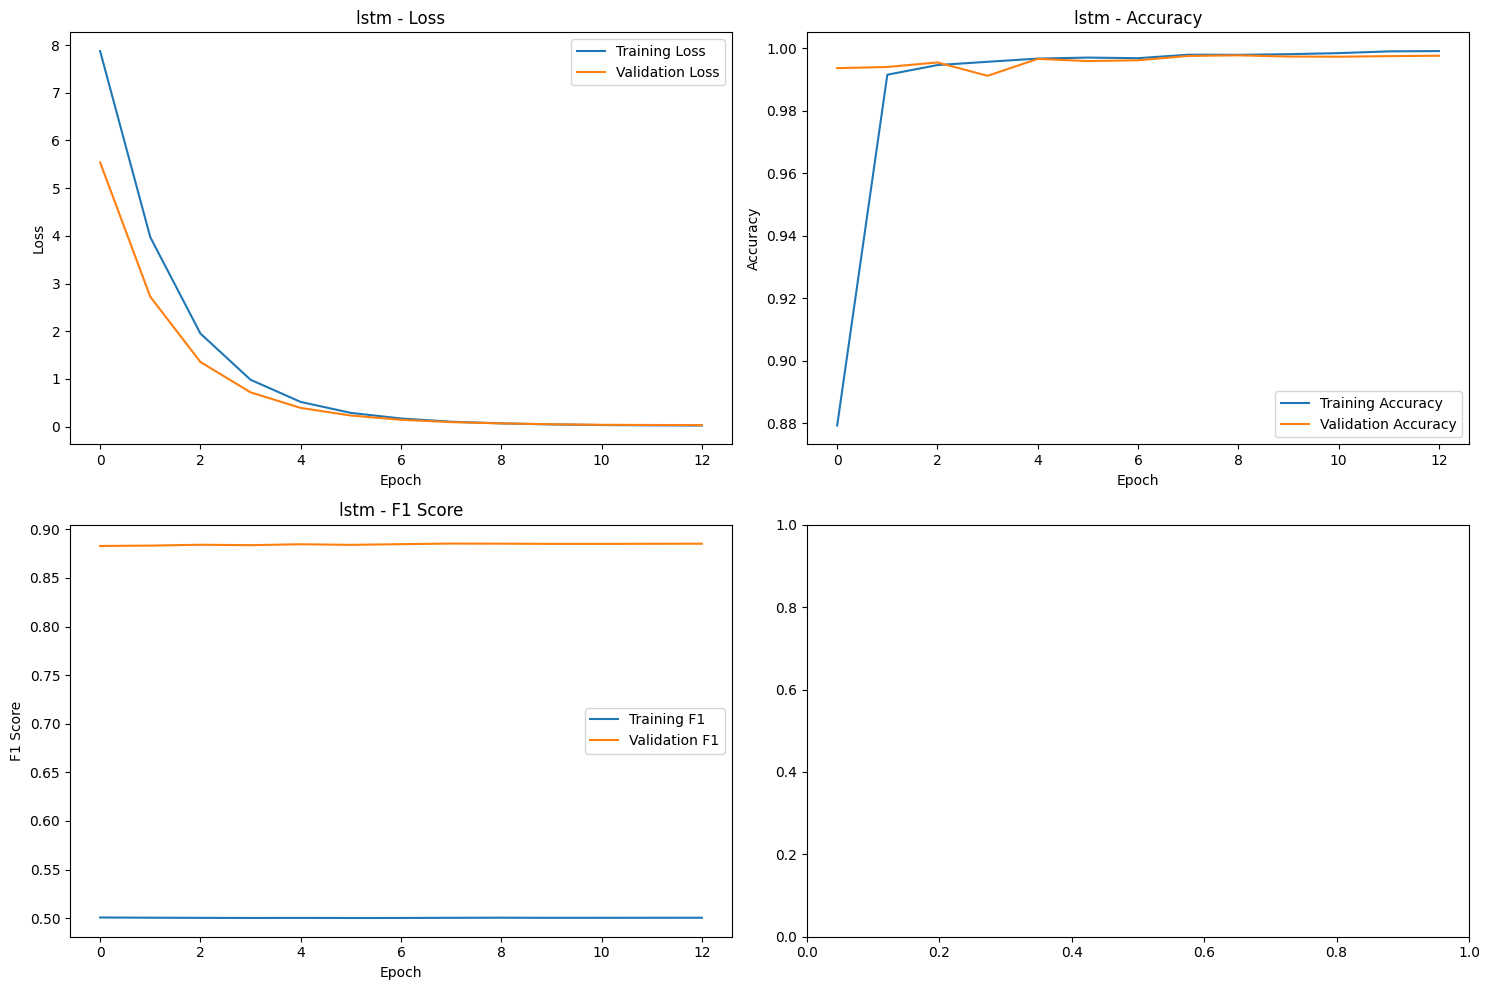


Preparing TRANSFORMER model...
Scaler saved to saved_models/transformer_scaler.joblib
Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - accuracy: 0.9438 - f1_score: 0.4981 - loss: 0.1370 - val_accuracy: 0.9947 - val_f1_score: 0.8842 - val_loss: 0.0256 - learning_rate: 5.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.9986 - f1_score: 0.4997 - loss: 0.0104 - val_accuracy: 0.9969 - val_f1_score: 0.8850 - val_loss: 0.0195 - learning_rate: 5.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9992 - f1_score: 0.4980 - loss: 0.0059 - val_accuracy: 0.9970 - val_f1_score: 0.8852 - val_loss: 0.0209 - learning_rate: 5.0000e-04
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9994 - f1_score: 0.5030 - loss: 0.0046 - val_accuracy: 0.9955 - val_f1_score: 0.8847 - val_loss: 0.0259 - learning_rate: 5.0000e-04
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9997 - f1_score: 0.5000 - loss: 0.0026 - val_accurac

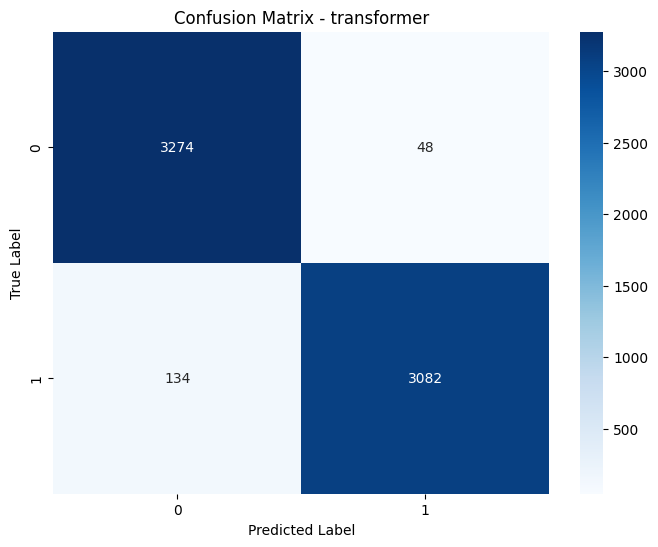

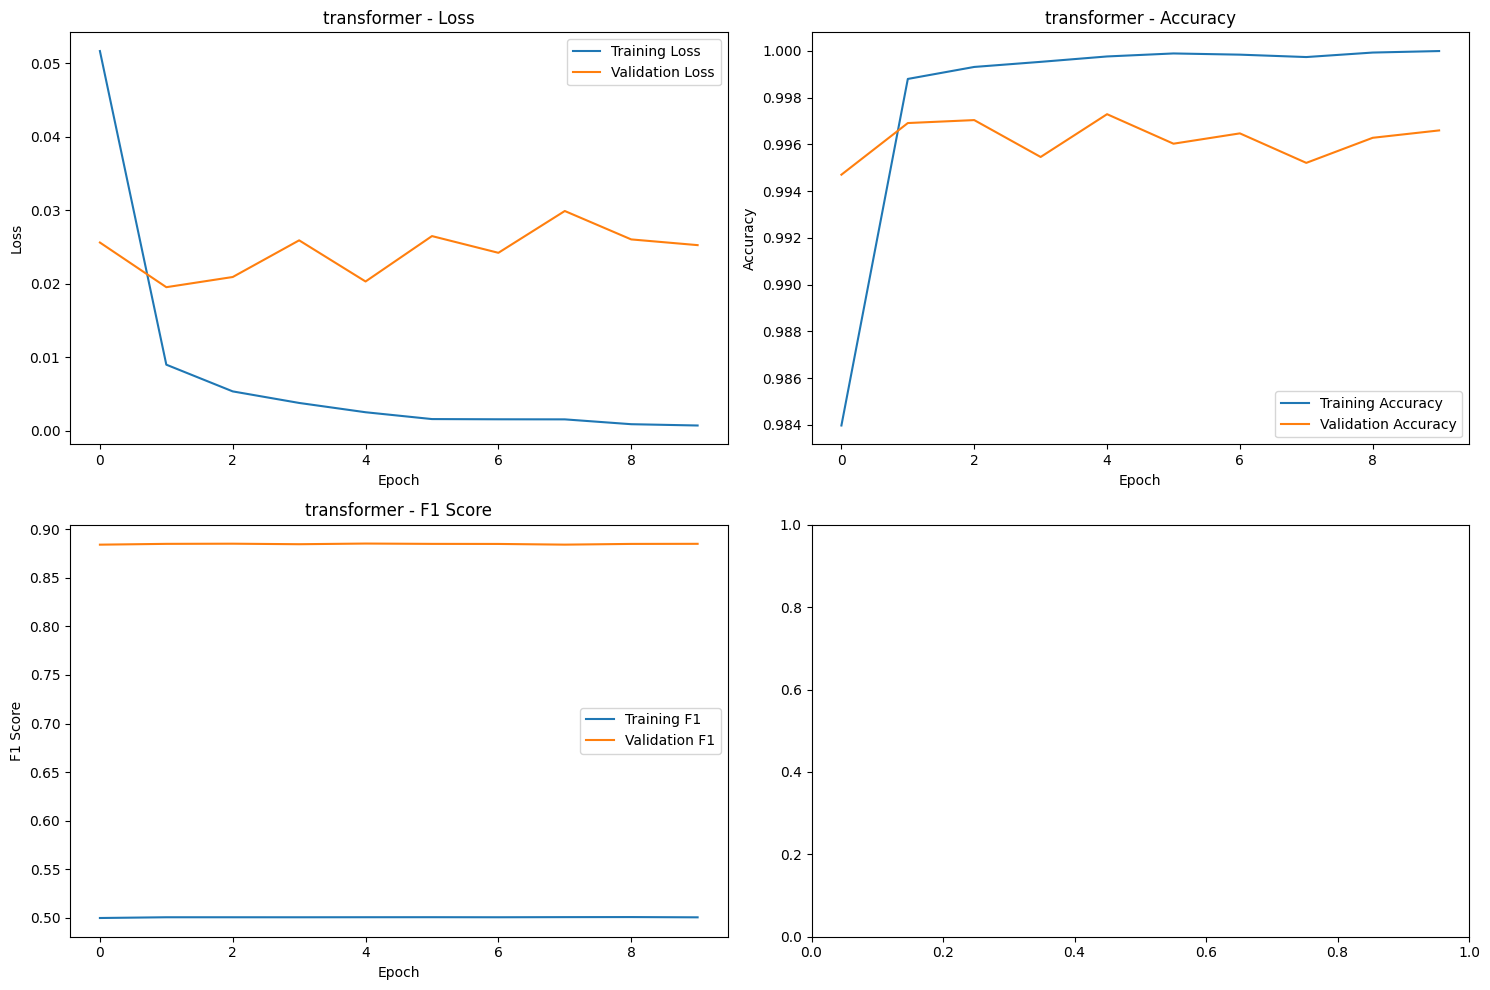


Evaluating Ensemble Methods...

VOTING Ensemble Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3322
           1       0.99      0.99      0.99      3216

    accuracy                           0.99      6538
   macro avg       0.99      0.99      0.99      6538
weighted avg       0.99      0.99      0.99      6538



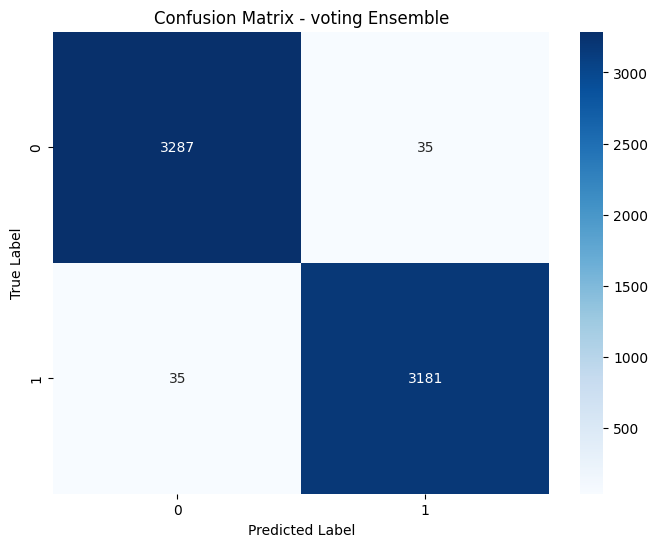


WEIGHTED_VOTING Ensemble Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3322
           1       0.99      0.99      0.99      3216

    accuracy                           0.99      6538
   macro avg       0.99      0.99      0.99      6538
weighted avg       0.99      0.99      0.99      6538



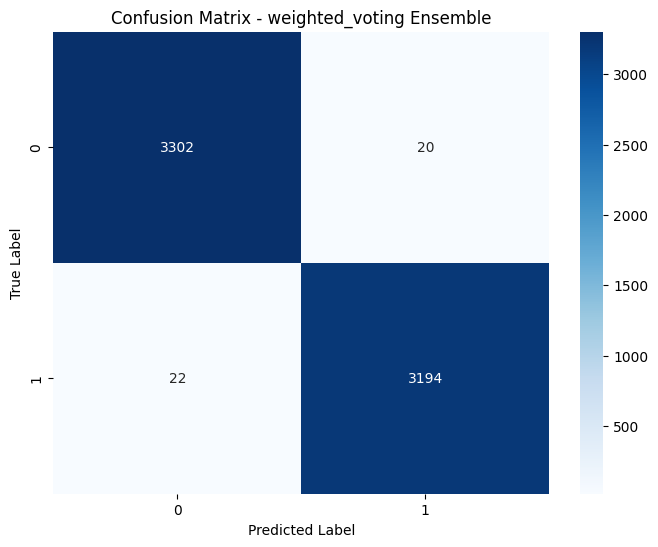


BAGGING Ensemble Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3322
           1       0.98      0.99      0.98      3216

    accuracy                           0.99      6538
   macro avg       0.99      0.99      0.99      6538
weighted avg       0.99      0.99      0.99      6538



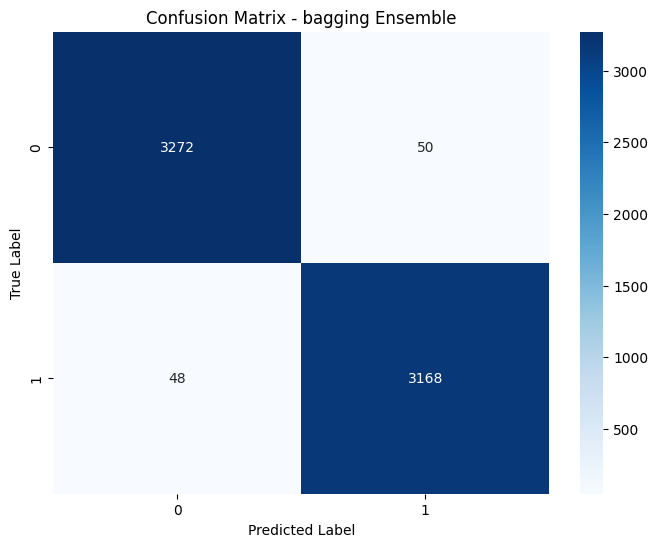


Total execution time: 91.49 minutes


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import time

def plot_confusion_matrix(y_true, y_pred, model_name):
    """혼동 행렬 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_history(history, model_name):
    """학습 히스토리 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0,0].plot(history.history['loss'], label='Training Loss')
    axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0,0].set_title(f'{model_name} - Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

    # Accuracy
    axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0,1].set_title(f'{model_name} - Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()

    # F1 Score
    axes[1,0].plot(history.history['f1_score'], label='Training F1')
    axes[1,0].plot(history.history['val_f1_score'], label='Validation F1')
    axes[1,0].set_title(f'{model_name} - F1 Score')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, history=None):
    """모델 평가 및 시각화"""
    print(f"\nEvaluating {model.model_name.upper()} Model:")

    # 예측
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_test_encoded = model.encoder.transform(y_test)

    # 분류 보고서
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred))

    # 혼동 행렬
    plot_confusion_matrix(y_test_encoded, y_pred, model.model_name)

    # 학습 곡선 (히스토리가 있는 경우)
    if history is not None:
        plot_training_history(history, model.model_name)

def create_ensemble_predictions(models, X, method='voting'):
    """앙상블 예측 생성"""
    predictions = np.array([model.predict(X) for model in models])

    if method == 'voting':
        # 하드 보팅
        return (np.mean(predictions > 0.5, axis=0) > 0.5).astype(int)
    elif method == 'weighted_voting':
        # 가중치 보팅 (각 모델의 검증 성능에 따른 가중치 적용)
        weights = [0.3, 0.5, 0.2]
        weighted_pred = np.average(predictions, axis=0, weights=weights)
        return (weighted_pred > 0.5).astype(int)
    elif method == 'bagging':
        # 배깅 (랜덤 서브셋으로 예측)
        n_samples = predictions.shape[1]
        bagged_pred = np.zeros(n_samples)
        for i in range(n_samples):
            subset = np.random.choice(predictions.shape[0], size=predictions.shape[0], replace=True)
            bagged_pred[i] = (np.mean(predictions[subset, i]) > 0.5)
        return bagged_pred.astype(int)
    else:
        raise ValueError(f"Unknown ensemble method: {method}")

def main(gru_model, lstm_model, transformer_model, X_train, y_train, X_val, y_val, X_test, y_test):
    try:
        total_start_time = time.time()
        models = [gru_model, lstm_model, transformer_model]
        histories = {}

        # 모델 학습 또는 로드
        for model in models:
            print(f"\nPreparing {model.model_name.upper()} model...")
            history = model.train(X_train, y_train, X_val, y_val,
                                f"saved_models/best_{model.model_name}_model.keras")
            histories[model.model_name] = history

            # 개별 모델 평가
            evaluate_model(model, X_test, y_test, history)

        # 앙상블 평가
        print("\nEvaluating Ensemble Methods...")
        ensemble_methods = ['voting', 'weighted_voting', 'bagging']

        for method in ensemble_methods:
            print(f"\n{method.upper()} Ensemble Results:")
            y_pred = create_ensemble_predictions(models, X_test, method)
            y_test_encoded = models[0].encoder.transform(y_test)

            print("\nClassification Report:")
            print(classification_report(y_test_encoded, y_pred))
            plot_confusion_matrix(y_test_encoded, y_pred, f"{method} Ensemble")

        total_time = time.time() - total_start_time
        print(f"\nTotal execution time: {total_time/60:.2f} minutes")

    except Exception as e:
        print(f"\nError in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    # 모델 생성
    print("Initializing models...")
    gru_model = AudioFakeDetectorGRU(timesteps=15, learning_rate=0.0005)
    lstm_model = AudioFakeDetectorLSTM(timesteps=15, learning_rate=0.0005)
    transformer_model = AudioFakeDetectorTransformer(timesteps=15, learning_rate=0.0005)

    # 데이터 로드
    print("\nLoading training data...")
    X_train, y_train, X_val, y_val, X_test, y_test, feature_cols = load_and_preprocess_data(
        '/content/drive/Shareddrives/Data/전처리/features.csv',
        is_training=True
    )

    # 메인 실행
    main(gru_model, lstm_model, transformer_model,
         X_train, y_train, X_val, y_val, X_test, y_test)